In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Custom Loss Function

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full,X_test,y_train_full,y_test = train_test_split(housing.data,
                                                           housing.target.reshape(-1,1),random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_valid_scalled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [3]:
y_test

array([[0.477  ],
       [0.458  ],
       [5.00001],
       ...,
       [1.177  ],
       [2.631  ],
       [4.815  ]])

In [4]:
def huber_fn(y_true,y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error,squared_loss,linear_loss)

Saving figure huber_loss.png


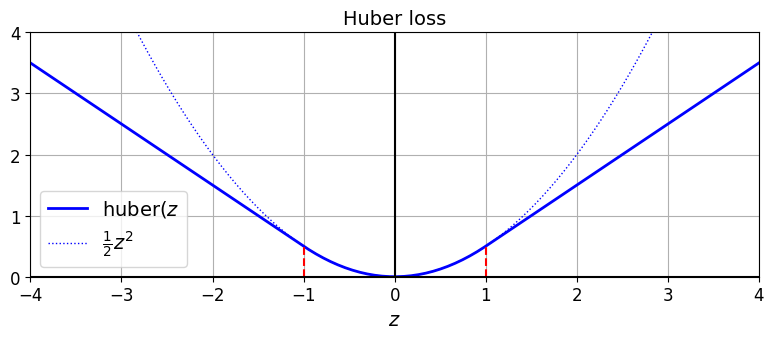

In [5]:
plt.figure(figsize=(8,3.5))
z = np.linspace(-4,4,200)
plt.plot(z,huber_fn(0,z),"b-",linewidth=2,label="huber($z$")
plt.plot(z,z**2 / 2, "b:",linewidth=1,label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
save_fig("huber_loss.png")
plt.show()

In [6]:
input_shape = X_train.shape[1:] # 8
model_1 = keras.models.Sequential([
    keras.layers.Dense(30,activation="selu",kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [7]:
model_1.compile(loss=huber_fn,optimizer="nadam",metrics=["mse"])

In [8]:
model_1.fit(X_train,y_train,epochs=10,validation_data=[X_valid,y_valid])

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 8.6957 - mse: 192.5037 - val_loss: 6.5935 - val_mse: 127.4433
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 3.7416 - mse: 32.5135 - val_loss: 1.3268 - val_mse: 11.2970
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 2.8515 - mse: 20.1265 - val_loss: 2.4982 - val_mse: 14.4796
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 2.4720 - mse: 15.2569 - val_loss: 3.1037 - val_mse: 25.3131
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 2.2153 - mse: 12.7074 - val_loss: 2.1445 - val_mse: 13.3448
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 2.0034 - mse: 10.7746 - val_loss: 1.1794 - val_mse: 6.6127
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 1.8736 - mse: 9.7841 - val_loss: 0.9633 - val_mse: 6.0810
Epoch 8/10
363/363 [==============================] - 0s 1ms/st

# Saving / Loading models with custom objects

In [9]:
# saving the custome model
model_1.save("model_1_with_custom_loss.h5")

In [10]:
model_1_load = keras.models.load_model("model_1_with_custom_loss.h5",
                                       custom_objects={"huber_fn":huber_fn})

In [11]:
model_1_load.fit(X_train_scalled,y_train,epochs=2,
                 validation_data=[X_valid_scalled,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.3646 - mse: 1.3827 - val_loss: 0.4038 - val_mse: 37.2830
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2558 - mse: 0.9243 - val_loss: 0.3639 - val_mse: 32.4104


1. Create the hubber function with the spesific theresold

In [12]:
def create_huber(thereshold=1.0):
    def huber_fn(y_true,y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < thereshold
        squared_loss = tf.square(error) /2
        linear_loss = thereshold * tf.abs(error) - thereshold ** 2 / 2
        return tf.where(is_small_error,squared_loss,linear_loss)
    return huber_fn

custom object (theresold isnt save on save models) must be eksplisit on the load models

In [13]:
input_shape = X_train.shape[1:]

model_2 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])



In [14]:
model_2.compile(loss=create_huber(2.0),optimizer="nadam",metrics=["mae"])


In [15]:
model_2.fit(X_train_scalled,y_train,epochs=2,
            validation_data=[X_valid_scalled,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.8424 - mae: 0.9687 - val_loss: 0.2742 - val_mae: 0.5242
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2394 - mae: 0.5101 - val_loss: 0.2210 - val_mae: 0.4915


In [16]:
model_2.save("model_2_with_custom_loss_thershold.h5")


In [17]:
model_2 = keras.models.load_model("model_2_with_custom_loss_thershold.h5",
                                  custom_objects={"huber_fn":create_huber(2.0)})

untuk menghindari custom objects by parameter bisa digunakan class dengan ditambahkan get config dari parent class keras.losses.loss

In [18]:
class HuberLoss(keras.losses.Loss):
    def __init__(self,threshold=1.0,**kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self,y_true,y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config=super().get_config()
        return {**base_config,"threshold":self.threshold}

In [19]:
model_3 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [20]:
model_3.compile(loss=HuberLoss(2.0),optimizer="nadam",
                metrics=["mae"])

In [21]:
model_3.fit(X_train_scalled,y_train,epochs=2,
            validation_data=[X_valid,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.7663 - mae: 0.9262 - val_loss: 124.5908 - val_mae: 63.2846
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2432 - mae: 0.5180 - val_loss: 74.7052 - val_mae: 38.3378


In [22]:
model_3.save("model_3_with_custom_loss_class.h5")

In [23]:
model_3 = keras.models.load_model("model_3_with_custom_loss_class.h5",
                                  custom_objects={"HuberLoss":HuberLoss})

In [24]:
model_3.fit(X_train_scalled,y_train,epochs=2,
            validation_data=[X_valid,y_valid])

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2283 - mae: 0.5015 - val_loss: 60.1808 - val_mae: 31.0787
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2219 - mae: 0.4922 - val_loss: 71.8824 - val_mae: 36.9366


In [25]:
model_3.loss.threshold

2.0

# Other Custom Functions

In [26]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [28]:
layer = keras.layers.Dense(1,activation=my_softplus,
                           kernel_initializer = my_glorot_initializer,
                           kernel_regularizer= my_l1_regularizer,
                           kernel_constraint = my_positive_weights)

In [29]:
model_4 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [30]:
model_4.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [31]:
model_4.fit(X_train_scalled, y_train, epochs=2,
          validation_data=(X_valid_scalled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.0125 - mae: 1.0132 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6258 - mae: 0.5279 - val_loss: 2.8053 - val_mae: 0.5339


In [32]:
model_4.save("my_model_with_many_custom_parts.h5")

In [33]:
model_4 = keras.models.load_model("my_model_with_many_custom_parts.h5",
                                  custom_objects={
                                        "my_l1_regularizer": my_l1_regularizer,
                                        "my_positive_weights": my_positive_weights,
                                        "my_glorot_initializer": my_glorot_initializer,
                                        "my_softplus": my_softplus,
                                  })

In [34]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self,factor):
        self.factor = factor
    def __call__(self,weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor":self.factor}

In [35]:
model_5 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [36]:
model_5.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [37]:
model_5.fit(X_train_scalled, y_train, epochs=2,
          validation_data=(X_valid_scalled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.4313 - mae: 0.8508 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6202 - mae: 0.5163 - val_loss: inf - val_mae: inf


In [38]:
model_5.save("my_model_with_many_custom_parts.h5")

In [39]:
model_5 = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

# Custom metrics

In [40]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
model_6 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [42]:
model_6.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])


In [43]:
model_6.fit(X_train_scalled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 798us/step - loss: 1.8960 - huber_fn: 0.8000
Epoch 2/2
363/363 [==============================] - 0s 773us/step - loss: 0.5667 - huber_fn: 0.2433


**Note**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [44]:
model_6.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [45]:
sample_weight = np.random.rand(len(y_train))
history = model_6.fit(X_train_scalled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 855us/step - loss: 0.1146 - huber_fn: 0.2317
Epoch 2/2
363/363 [==============================] - 0s 817us/step - loss: 0.1109 - huber_fn: 0.2245


1. Stremming metric

In [46]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [47]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [48]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [49]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [50]:
precision.reset_state() # rest state on variables

Creating streaming metric

In [51]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [52]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [53]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [54]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [55]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Check hubermetric class work well

In [56]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
model_7 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [58]:
model_7.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [59]:
model_7.fit(X_train_scalled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 764us/step - loss: 0.7861 - huber_metric: 0.7861
Epoch 2/2
363/363 [==============================] - 0s 798us/step - loss: 0.2469 - huber_metric: 0.2469


In [60]:
model_7.save("my_model_with_a_custom_metric.h5")

In [61]:
model_7 = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [62]:
model_7.fit(X_train_scalled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 812us/step - loss: 0.2303 - huber_metric: 0.2303
Epoch 2/2
363/363 [==============================] - 0s 769us/step - loss: 0.2213 - huber_metric: 0.2213


In [63]:
model_7.metrics[-1].threshold

2.0

Huberclass can from lib

In [64]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

In [65]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
model_8 = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [67]:
model_8.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [68]:
sample_weight = np.random.rand(len(y_train))
history = model_8.fit(X_train_scalled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 851us/step - loss: 0.3713 - HuberMetric: 0.7481
Epoch 2/2
363/363 [==============================] - 0s 907us/step - loss: 0.1215 - HuberMetric: 0.2449


In [69]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.37126243114471436, 0.37126253083440175)

In [70]:
model_8.save("my_model_with_a_custom_metric_v2.h5")

In [71]:
model_8 = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [72]:
model_8.fit(X_train_scalled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 826us/step - loss: 0.2335 - HuberMetric: 0.2335
Epoch 2/2
363/363 [==============================] - 0s 820us/step - loss: 0.2263 - HuberMetric: 0.2263


In [73]:
model_8.metrics[-1].threshold

2.0

# Custome layers

- to create the custom layer can be wrap to lambda functional on the function set up 

In [74]:
exponential_layer = keras.layers.Lambda(lambda x : tf.exp(x))


In [75]:
exponential_layer([-1.,0.,1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very deifferent scales (1e-3,1e1,1e4)

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model_9 = keras.models.Sequential([
    keras.layers.Dense(30,activation="relu",input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])

In [78]:
model_9.compile(loss="mse",optimizer="sgd")
model_9.fit(X_train_scalled,y_train,epochs=5,
            validation_data= [X_valid_scalled,y_valid])
model_9.evaluate(X_test_scaled,y_test)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.8132 - val_loss: 0.4472
Epoch 2/5
363/363 [==============================] - 0s 986us/step - loss: 0.4200 - val_loss: 0.3663
Epoch 3/5
363/363 [==============================] - 0s 997us/step - loss: 0.3891 - val_loss: 0.3465
Epoch 4/5
363/363 [==============================] - 0s 936us/step - loss: 0.3798 - val_loss: 0.3470
Epoch 5/5
162/162 [==============================] - 0s 733us/step - loss: 0.3603


0.36026594042778015

In [79]:
# custom the dense layers
class MyDense(keras.layers.Layer):
    #initialiation hyperparameter thershold
    def __init__(self,units,activation=None,**kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
    
    # create the arsitecture kernel(weights neuron connection) & bias
    def build(self,batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel",shape=[batch_input_shape[-1],self.units],
            initializer="glorot_normal"
        )
        self.bias = self.add_weight(
            name="bias",shape=[self.units],
            initializer="zeros"
        ) 
        #to be know the arsitecture has been created
        super().build(batch_input_shape)
    # forward pass
    def call(self,X):
        return self.activation(X @ self.kernel + self.bias)

    # output shape -> input shape to next layer
    def compute_output_shape(self,batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.bias])
    
    # config the theresold must be saved on classes
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,"units":self.units,
                "activation":keras.activations.serialize(self.activation)}

In [80]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
model_10 = keras.models.Sequential([
    MyDense(30,activation="relu",input_shape=input_shape),
    MyDense(1)
])

In [82]:
model_10.compile(loss="mse",optimizer="nadam")
model_10.fit(X_train_scalled,y_train,epochs=5,
             validation_data=[X_valid_scalled,y_valid])

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 1.4899 - val_loss: 2.1341
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6141 - val_loss: 0.8687
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4856 - val_loss: 0.5723
Epoch 4/5
363/363 [==============================] - 0s 976us/step - loss: 0.4328 - val_loss: 0.4590
Epoch 5/5
363/363 [==============================] - 0s 985us/step - loss: 0.4114 - val_loss: 0.4015


In [83]:
model_10.save("model_with_custom_layer.h5")

In [84]:
model_10 = keras.models.load_model("model_with_custom_layer.h5",
                                   custom_objects={"MyDense":MyDense})

In [85]:
model_10.fit(X_train_scalled,y_train,epochs=5,
             validation_data=[X_valid_scalled,y_valid])

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.3976 - val_loss: 0.4038
Epoch 2/5
363/363 [==============================] - 0s 991us/step - loss: 0.3899 - val_loss: 0.5690
Epoch 3/5
363/363 [==============================] - 0s 995us/step - loss: 0.3846 - val_loss: 0.3629
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3776 - val_loss: 0.3568
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3729 - val_loss: 0.3700


# Custome layer with multiple_inputs or multiple_outputs

In [86]:
# 2 inputs and 3 outputs
class MyMultiLayer(keras.layers.Layer):
    def call(self,X):
        X1,X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)
        return X1 + X2, X1 * X2,X1 / X2
    
    def compute_output_shape(self,batch_input_shape):
        batch_input_shape1,batch_input_shape2,batch_input_shape3 = batch_input_shape
        return [batch_input_shape1,batch_input_shape2,batch_input_shape3]

In [87]:
# Multiple input cant handle with sequential models (only 1 inputs and 1 outputs)

inputs1 = keras.layers.Input(shape=[3])
inputs2 = keras.layers.Input(shape=[3])
outpus1,outputs2,outputs3 = MyMultiLayer()((inputs1,inputs2))

X1.shape:  (None, 3)  X2.shape:  (None, 3)


Note that the `call()` method receives symbolic inputs, whose shape is only partially specified (at this stage, we don't know the batch size, which is why the first dimension is `None`):

We can also pass actual data to the custom layer. To test this, let's split each dataset's inputs into two parts, with four features each:

In [88]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count //2
    return data[:,:half], data[:,half:]
X_train_scaled_A, X_train_scaled_B = split_data(X_train_scalled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scalled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape


((11610, 4), (11610, 4))

In [89]:
outputs1, outputs2,outputs3 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


In [90]:
print(outputs1)
print(outputs2)
print(outputs3)


tf.Tensor(
[[-0.17324547 -1.6507294  -0.01412493 -1.4073021 ]
 [ 2.6134481  -1.6637297  -0.5110694   0.86339283]
 [-0.5025582  -0.27013135  2.1268167  -0.6402433 ]
 ...
 [-0.7709261   0.6388412  -1.2357894   1.4055338 ]
 [-0.9933209   1.8356445   0.41289914 -0.16435926]
 [ 0.7240328   0.00968345  1.4208122  -1.4639156 ]], shape=(11610, 4), dtype=float32)
tf.Tensor(
[[-0.00402183  0.61749667 -0.8766508  -0.02112347]
 [ 1.3997903  -0.38343248 -0.37163973 -0.2558276 ]
 [ 0.03643769 -0.00890543  1.0706553  -1.7933904 ]
 ...
 [-0.5534281   0.0678305   0.371412    0.29685235]
 [ 0.05403009 -0.02504723 -0.0567511   0.0063295 ]
 [-0.15393297 -0.03349337  0.3358127   0.2048483 ]], shape=(11610, 4), dtype=float32)
tf.Tensor(
[[-9.3558846e+00  1.8812752e+00 -1.0152001e+00 -1.0444104e-02]
 [ 4.0397388e-01 -9.1092148e+00 -4.4239715e-01 -2.1271384e-01]
 [ 4.7195277e+00 -9.9059708e-02  6.2510151e-01 -6.2272650e-01]
 ...
 [-2.7040911e+00  3.7500737e+00  7.1688426e-01  2.2577792e-01]
 [ 1.6200068e+01 -

Build more complete model using the functional API

In [91]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B,hidden_C = MyMultiLayer()((input_A,input_B))

hidden_A = keras.layers.Dense(30,activation="selu")(hidden_A)
hidden_B = keras.layers.Dense(30,activation="selu")(hidden_B)
hidden_C = keras.layers.Dense(30,activation = "selu")(hidden_C)
concat = keras.layers.Concatenate()((hidden_A,hidden_B,hidden_C))
output = keras.layers.Dense(1)(concat)
model_11 = keras.models.Model(inputs=[input_A,input_B],outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [92]:
model_11.compile(loss='mse', optimizer='nadam')

In [93]:
model_11.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=5,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/5
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 1s 1ms/step - loss: 238.2614 - val_loss: 64.1189
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 17.5969 - val_loss: 10.4930
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 1.3888 - val_loss: 4.3007
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 1.2202 - val_loss: 1.3437
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 2.4090 - val_loss: 58.6377


- create layer with different behavior during training and testing

In [94]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self,stddev,**kwargs) :
        super().__init__(**kwargs)
        self.stddev = stddev
    
    def call(self,X,training=None):
        if training:
            noise = tf.random.normal(tf.shape(X),stddev=self.stddev)
            return X + noise
        else :
            return X
    def compute_output_shape(self,batch_input_shape):
        return batch_input_shape

In [95]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model_12 = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [96]:
model_12.compile(loss="mse", optimizer="nadam")
model_12.fit(X_train_scalled, y_train, epochs=5,
          validation_data=(X_valid_scalled, y_valid))
model_12.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 2.4826 - val_loss: 8.1577
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 1.0973 - val_loss: 5.4373
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 1.0629 - val_loss: 3.4268
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 1.0405 - val_loss: 2.1728
Epoch 5/5
162/162 [==============================] - 0s 673us/step - loss: 0.8205


0.8204621076583862

In [100]:
for i in range (1+3):
    print(i)

0
1
2
3


# Custom Models

In [98]:
X_new_scaled = X_test_scaled

In [99]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self,n_layers,n_neurons,**kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons,activation="elu",
                                          kernel_initializer="he_normal")
        for _ in range(n_layers)]
        
    def call(self,inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z


In [101]:
class ResidualRegressor(keras.models.Model):
    def __init__(self,output_dim,**kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30,activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2,30)
        self.block2 = ResidualBlock(2,30)
        self.out = keras.layers.Dense(output_dim)
    
    def call(self,inputs):
        Z = self.hidden1(inputs)
        for _ in range(1+3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)
    

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
model_13 = ResidualRegressor(1)
model_13.compile(loss="mse",optimizer="nadam")
history_13 = model_13.fit(X_train_scalled,y_train,epochs=5)
score = model_13.evaluate(X_test_scaled,y_test)
y_pred = model_13.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 1ms/step - loss: 12.9798
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 3.9566
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 1.7793
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6661
Epoch 5/5
162/162 [==============================] - 0s 770us/step


In [104]:
model_13.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


In [105]:
model_13 = keras.models.load_model("my_custom_model.ckpt")

In [107]:
history = model_13.fit(X_train_scalled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4746
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.9560
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6148
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 1.3728
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5478


We could have defined the model using the sequential API instead

In [108]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [110]:
block1=ResidualBlock(2,30)
model_14 = keras.models.Sequential([
    keras.layers.Dense(30,activation="elu",kernel_initializer="he_normal"),
    block1,
    block1,
    block1,
    block1,
    ResidualBlock(2,30),
    keras.layers.Dense(1)
])

In [111]:
model_14.compile(loss="mse", optimizer="nadam")
history = model_14.fit(X_train_scalled, y_train, epochs=5)
score = model_14.evaluate(X_test_scaled, y_test)
y_pred = model_14.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.7863
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5023
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3875
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3543
Epoch 5/5
162/162 [==============================] - 0s 708us/step


# Losees and Metrics Based on Model Internals

**Note**: the following code has two differences with the code in the book:
1. It creates a `keras.metrics.Mean()` metric in the constructor and uses it in the `call()` method to track the mean reconstruction loss. Since we only want to do this during training, we add a `training` argument to the `call()` method, and if `training` is `True`, then we update `reconstruction_mean` and we call `self.add_metric()` to ensure it's displayed properly.
2. Due to an issue introduced in TF 2.2 ([#46858](https://github.com/tensorflow/tensorflow/issues/46858)), we must not call `super().build()` inside the `build()` method.

In [134]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(5e-2 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [130]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [135]:
model_15 = ReconstructingRegressor(1)
model_15.compile(loss="mse", optimizer="nadam")
history = model_15.fit(X_train_scalled, y_train, epochs=2)
y_pred = model_15.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.7076 - reconstruction_error: 0.8598
Epoch 2/2
162/162 [==============================] - 0s 721us/step
